# What are the common activities that the victims were engaged in prior to the accident?

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 23 15:12:27 2017

@author: leeto
"""
import os
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.util import ngrams
from nltk.tag.util import *
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import xlsxwriter

# List Of Category indexes as per stated in the CA document

In [2]:
CategoryIndexes = {"Caught in/between Objects":0,
                     "Falls":1,
                     "Drowning":2,
                     "Other":3,
                     "Others":3,
                     "Struck By Moving Objects":4,
                     "Collapse of object":5,
                     "Fires and Explosion":6,
                     "Electrocution":7,
                     "Suffocation":8,
                     "Exposure to Chemical Substances":9,
                     "Exposure to extreme temperatures":10,
                     }
CategoryNames = {0:"Caught in/between Objects",
                     1:"Falls",
                     2:"Drowning",
                     3:"Other",
                     4:"Struck By Moving Objects",
                     5:"Collapse of object",
                     6:"Fires and Explosion",
                     7:"Electrocution",
                     8:"Suffocation",
                     9:"Exposure to Chemical Substances",
                     10:"Exposure to extreme temperatures",
                     }

# Classes to store the category and case items together with helper functions

In [3]:
def GetCategoryIndex(Name):
    if Name in CategoryIndexes:
        return CategoryIndexes[Name]
    else:
        return -1
    
def GetCategoryName(Index):
    if (Index in CategoryNames):
        return CategoryNames[Index]
    else:
        return "Invalid Category"
        
#Classes To Be Used 
class Category(object):
    def __init__(self, Name, Index):
        self.Name = Name
        self.Index = Index
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []
        
    def __str__(self):
        return("Category Item:\n"
               "  Name = {0}({1})\n"
               "  ActivityVerb = {2}\n"
               "  ActivityChunk = {3}\n"
               .format(self.Name, self.Index, str(len(self.ActivityTokensVerb)) , str(len(self.ActivityTokensChunk))))
        
class CaseItem(object):
    def __init__(self, Title, Summary, CauseName, CauseIndex):
        self.CauseName = CauseName
        self.CauseIndex = CauseIndex
        self.Title = Title
        self.Summary = Summary
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []

    def __str__(self):
        return("Case Item:\n"
               "  Cause = {0}({1})\n"
               "  Title = {2}\n"
               "  Summary = {3}\n"
               .format(self.CauseName, self.CauseIndex, self.Title, self.Summary))

# Read from and write to excel, populate case items, intialization of categories

In [4]:
#read from excel, populate case items
def ReadFromExcelAndPopulateCase():
    global MsiaCaseItems 
    global OshaCaseItems
    global OshaCasesDF
    global MsiaCasesDF
    MsiaCaseItems = []
    OshaCaseItems = []
    MsiaCasesDF=pd.read_excel(MsiaCasesFile,sheetname=0)
    OshaCasesDF=pd.read_excel(OshaCasesFile,sheetname=0)
    MsiaCasesDF.groupby('Cause ').describe()
    # For each row in the column,
    for index,row in MsiaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title Case'], row['Summary Case'], row['Cause '], GetCategoryIndex(row['Cause ']))
        MsiaCaseItems.append(TempCaseItem)
    # For each row in the column,
    for index,row in OshaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title'], row['Summary'], row['Cause'], GetCategoryIndex(row['Cause']))
        OshaCaseItems.append(TempCaseItem)

#Initialize Categories array
def InitializeCategories():
    global MsiaCategories
    global OshaCategories
    MsiaCategories = []
    OshaCategories = []
    for index in CategoryNames:
        tempcat = Category(GetCategoryName(index),index)
        MsiaCategories.append(tempcat)
        OshaCategories.append(tempcat)
        
def write_to_file(filename, text):
    f = open(filename, 'a')
    f.write(text + '\n')  # python will convert \n to os.linesep
    f.close()  # you can omit in most cases as the destructor will call it
    
def WriteToExcel(filename, SelectedCaseItemsDF):
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    # Convert the dataframe to an XlsxWriter Excel object.
    SelectedCaseItemsDF.to_excel(writer, sheet_name='Sheet1')
    # Close the Pandas Excel writer and output the Excel file.
    writer.save()    

# Visualisation function to plot frequency distribution, word cloud and list some of the common activities

In [5]:
# Visualisation function to plot frequency distribution, word cloud and list some of the common activities
def Visualisation(category):   
    #tokens = word_tokenize(text)
    if (len(category.ActivityTokensVerb)>0):
        # frequecy distribution chart
        print(category.Name)
        #tokens_clean = [ t for t in category.ActivityTokensVerb if len(t) >= 3 ]
        tokens_clean_single = []
        for tok1 in category.ActivityTokensVerb:
            for tok2 in tok1:
                tokens_clean_single.append(tok2)
        fd = nltk.FreqDist(tokens_clean_single)
        fd.most_common(25)
        TopActivityTokens = fd.most_common(3)
        fd.plot(25)
        #print(tokens_clean_single)
        #print(TopActivityTokens)
        
        # ==== Installation of wordcloud package
        # 1. download wordcloud‑1.3.2‑cp36‑cp36m‑win_amd64.whl from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud 
        # 2. Copy the file to your current working directory
        # 3. Open command prompt from Tools
        # 4. python -m pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl
    
        # 1. Simple cloud
        # Generate a word cloud image
        # Take note that this function requires text string as input
        # text = "".join([' '+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
        wc = WordCloud(background_color="white")
        wc.generate_from_frequencies(fd)
        # Display the generated image:
        # the matplotlib way:
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()    
        
        chunks_limit = 10
        print("Top 3 activity word and their sentences")
        print("=======================================\n")
        for word in TopActivityTokens:
            chunks_count = 0
            underline = ""
            print('\n' + word[0])
            for c in word[0]:
                underline += '='
            print(underline + '\n')
            #Populate sentences belonging to top tokens
            for chunk1 in category.ActivityTokensChunk:
                for chunk2 in chunk1:
                    chunk_token = nltk.sent_tokenize(chunk2)
                    chunk_lemma_token = get_lemma(chunk_token)
                    #print(chunk_lemma_token)
                    #chunk_text = ' '.join(chunk)
                    if len(chunk_lemma_token) >= 1:
                        #print (chunk_lemma_token)
                        for token in chunk_lemma_token:
                            if word[0] in get_lemma_word(token.split(' ')[0]):
                                if (chunks_count < 10):
                                    print(chunk2)
                                chunks_count += 1

            print("\n")
    else:
        print("Visualisation Function : NO DATA AVAILABLE")



# Text Mining helper functions 
- get_lemma - lemmatizer to get the base word based on speech tag
- get_stem - similar to get_lemma but some of the base words are not correct, so I did not use this
- get_verb_count - returns number of verb word found in the sentence
- filter_off_unwanted chunks - custom filter to more accurately extract verb associated with the activities

In [6]:
def get_lemma(subtree):        
    return [ WNlemma.lemmatize(t, 'v') for t in subtree ]

def get_lemma_word(text):
    return WNlemma.lemmatize(text, 'v')

def get_stem(subtree):
    return [ Stemmer.stem(t) for t in subtree ]

def get_verb_count(subtree):
    verb_count = 0
    tokens = nltk.pos_tag(word_tokenize(str(subtree))) 
    for tok in tokens:
        if ('\'VBG\'' in str(tok)) or ('\'VB\'' in str(tok)):
            verb_count += 1
    return verb_count

def filter_off_unwanted_chunks(subtree):
    # first words : crashing, causing, involving, doing, being, falling
    filter_first_words = ['crash', 'cause', 'involve', 'do', 'be', 'fall', 'avoid', 'result', 'address', 'have']
    filter_all_words = ['kill', 'carry out work']
    filter_last_words = ['victim', 'work']
    filter_short_words = ['carry', 'perform']   
    for ffw in filter_first_words:
        if (ffw in get_lemma(untag(subtree))[0]):
            return False, subtree
    for flw in filter_last_words:
        if (flw in get_lemma(untag(subtree))[len(subtree)-1]):
            return False, subtree
    for fsw in filter_short_words:
        if ( fsw in str(' '.join(get_lemma(untag(subtree)))) and (len(subtree)<=2) ):
            return False,subtree
    for faw in filter_all_words:
        if ( faw in str(' '.join(get_lemma(untag(subtree)))) ):
            return False, subtree
    if get_verb_count(untag(subtree)) > 0:  
        return True, subtree
    else: 
        return False, subtree

def clean_up_chunk(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    return text

def clean_up_verb(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    text = text.replace(' ','')
    return text

# Main function to extract the activities sentences and verb
- 1st loop (ie. OCC1) is used for extracting the sentences containing the activities. The RegexpParser will look for verb in past tenses(VBD), base form(VB), past participle(VBN), present participle(VBG) etc that is constructed together with nouns(singular, plural, proper noun,) as well as preposition(IN), adjective(JJ), particle(PR).

- 2nd loop (ie. OCC2) is used to further extract the base verb that is found using OCC1.

In [7]:
def extract_activities_chunk_and_verb(text):
    chunk_grammar = r"""
        OCC1:{<VBG|VB>+<IN|DT|JJ|RP>*<NN|NN.*>+(<IN|DT|JJ|RP>*<VBG|VB>+<NN|NN.*>+)?}
    """

    verb_grammar = r"""
        OCC2:{<VBG|VB>+}
    """    
#   original OCC:{<VBG|VB>+<IN|DT|JJ|RP>?<NN|NN.*>+<VBG|VB>?}
    ExtractedActivitiesChunk = []
    ExtractedActivitiesVerb = []
    if (not text=="") and (len(text) >= 3):
        chunk_parser = nltk.RegexpParser(chunk_grammar)
        tokens_chunk = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        tagged_chunk = nltk.pos_tag(tokens_chunk)
        if (len(tagged_chunk) > 0):
            extract_chunk = chunk_parser.parse(tagged_chunk)
            for subtree_chunk in extract_chunk.subtrees(filter=lambda t: 'OCC1' in t.label()):  
                acceptChunk, processed_subtree_chunk = filter_off_unwanted_chunks(subtree_chunk)
                if (acceptChunk == True):
                    token_chunk_clean = untag(processed_subtree_chunk)
                    #token_chunk_clean_str = clean_up_chunk(str(get_lemma(token_chunk_clean)))
                    token_chunk_clean_str = clean_up_chunk(str(token_chunk_clean))
                    print(token_chunk_clean_str + "(" + str(get_verb_count(untag(processed_subtree_chunk))) + ")")
                    ExtractedActivitiesChunk.append(token_chunk_clean_str)
                    verb_parser = nltk.RegexpParser(verb_grammar)
                    tokens_verb = [word for sent in nltk.sent_tokenize(token_chunk_clean_str) for word in nltk.word_tokenize(sent)]
                    tagged_verb = nltk.pos_tag(tokens_verb)
                    if (len(tagged_verb) > 0):
                        extract_verbs = verb_parser.parse(tagged_verb)
                        for subtree_verb in extract_verbs.subtrees(filter=lambda t: 'OCC2' in t.label()):  
                            #print(subtree_verb)
                            tokens_verb_lem = get_lemma(untag(subtree_verb))   
                            tokens_verb_lem_clean = clean_up_verb(str(tokens_verb_lem))
                            #print(tokens_verb_lem_clean)
                            ExtractedActivitiesVerb.append(clean_up_verb(str(tokens_verb_lem_clean)))
    return ExtractedActivitiesChunk, ExtractedActivitiesVerb

# Main Loop
- Initializes the case and categories item
- create the lemmatizer and stemmer objects
- read from excel and populate the case and categories

In [8]:
# Initialize     
MsiaCategories = []
MsiaCaseItems = []
MsiaCasesDF = []
OshaCategories = []
OshaCaseItems = []
OshaCasesDF = []

MsiaCasesFile = 'MsiaAccidentCases.xlsx'
#the Osha case file must have the causes populated by the predictor model developed by Vincent
OshaCasesFile = 'osha1.xlsx'

#NLTK Objects
# lemmatize to convert to base words depending on speech tagging
WNlemma = nltk.WordNetLemmatizer()
# stemmer to get the base words
Stemmer = nltk.SnowballStemmer('english')   

#Initilize categories
InitializeCategories()
#Read data from excel and populate case items
ReadFromExcelAndPopulateCase()

# Flags to determine which data set to use. 
- ProcessMsiaDataSet for Msia Dataset
- ProcessOshaDataSet for Osha Dataset

In [9]:
# if False, means process the Osha dataset
ProcessMsiaDataSet = False
ProcessOshaDataSet = True

# Main Processing Section 1
- Loops through each case item then populate the activities sentences and verb token 

In [10]:
if ProcessMsiaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in MsiaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in MsiaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

In [11]:
if ProcessOshaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in OshaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in OshaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

cleaning repair(1)
installing ladder scaffold structure(1)
clothing point(1)
paving equipment operator(1)
earthmoving equip bulldozer maintenance(1)
installing arm fracture face abrasion(1)
handling ind trk operator(1)
loading ramp loading dock(2)
walking surface fall contusion abrasion(1)
grinding machine(1)
grinding machine(1)
sandblasting abrasive blasting(2)
rotating parts hand(1)
sandblasting abrasive blasting(2)
sandblasting face neck concussion(1)
sandblasting respirator(1)
grinding wheel(1)
sharpening machine glove thumb laceration rotating parts(2)
cleaning chemical burn ppe jet fuel hand(1)
hoisting mechanism(1)
loading machinist abrasive wheel(1)
handling rotating parts(2)
rotating parts work rules(1)
cleaning refinery(1)
packing hand conveyor belt roller(1)
cleaning conveyor(1)
clothing forearm(1)
rotating shaft(1)
clothing fracture rib work rules(1)
flying object abrasive wheel laceration fracture leg(1)
flying object fracture grinder(1)
flying object eye ppe(1)
rotating p

poisoning animal bite leg(1)
poisoning security guard(1)
cleaning tendon laceration puncture(1)
ring caught(1)
installing electronic equipment ladder electric(1)
loading dock overturn(1)
trimming fall ppe(1)
installing mobile home hydraulic jack slip(1)
moving equip tractor run(1)
rigging backing up fall(2)
decking antenna(1)
rigging antenna equipment failure rope communication tower(1)
welding electric arc arc welding maintenance fire burn ppe cutting(3)
burning earthmoving equip(2)
welding welding oil drum explosion burn(2)
welding lubricating fluid oil tank explosion gas gas(2)
welding burn arm lubricating fluid pipeline(2)
welding fire burn(1)
welding welding pipe explosion(2)
welding burn ppe clothing arc(2)
welding contusion abrasion(1)
welding burn ppe spark construction(1)
welding welding welder(2)
welding cable welding installing(3)
burning naphtha fire(1)
welding arc welding truck construction(2)
welding head(1)
welding vapor support posts(1)
welding repair slip(1)
welding pp

handling falling object bleach chemical burn leg(2)
deboning vapor(1)
printing printing press machine operator lockout(2)
reaching caught(1)
reaching nip point(1)
reaching struck(1)
printing press drain pipe blind reaching printing machine operator finger(3)
reaching blade finger(1)
reaching concrete mixer(1)
reaching falling object work rules(2)
reaching work rules(1)
descending fall(1)
reaching hand wrist laceration fracture equipment operator(1)
reaching point(1)
reaching work rules(1)
reaching guard(1)
reaching blade circular(1)
reaching unguarded maintenance eye(1)
reaching wire rope work rules(1)
molding machine(1)
rotating knife(1)
reaching millwright(1)
installing ladder(1)
loading dock dock mech malfunction metal block blocks(1)
refueling blocks(1)
loading truck(1)
cleaning janitor fall slip(1)
walking surface(1)
cleaning fan fan(1)
lubricating fluid fracture face blood clot brain hemorrhage eye(1)
servicing fire burn oil rig blowout(1)
servicing blowout(1)
installing pipe(1)


building knee ankle(1)
walking surface building(2)
loading truck(1)
building collapse burn fracture(1)
building collapse fall blood clot(1)
building building collapse(2)
building collapse(1)
loading truck grain(1)
building collapse(1)
landing stair(1)
descending fall head(1)
moving work surface(1)
pouring bull(1)
cementing hip struck(1)
loading seat belt(1)
felling bulldozer(1)
backing up unstable surface earthmoving equip(2)
earthmoving equip bulldozer dozer(1)
logging chain(1)
hoisting mechanism(1)
hoisting mechanism(1)
hoisting mechanism(1)
flying object bus(1)
jumping equipment failure wire rope platform(1)
jumping equipment failure fall(1)
installing retaining wall collapse(2)
refueling hand face burn(1)
pouring burn chemical burn leg ppe hose(1)
lighting poor visibility(1)
descending mechanic vehicle bus maintenance abrasion contusion(1)
burning bolt scrap yard(1)
testing electric shock(1)
installing electrician electrical work busbar elec(1)
lighting circuit busbar(1)
installing

logging choker cable choker choker setter(1)
logging choker brake slope(1)
sling choker tag line(1)
logging rigging choker fracture shoulder arm(2)
flying object log(1)
logging log choker choker cable choker setter shoulder rigging contusion abrasion(2)
logging wire rope(1)
logging choker setter heat exhaustion heat(1)
logging choker setter inattention(1)
rigging choker setter(1)
logging fracture foot choker setter choker cable choker(1)
logging winch roller(1)
logging choker cable log(1)
yarding equipment failure pelvis work rules(1)
flying object unconsciousness neck choker cable choker setter(1)
rigging crane choker choker cable(1)
logging rigging choker setter(2)
logging choker setter(1)
logging choker setter(1)
logging mech malfunction(1)
riding on equipment(1)
disconnecting means(1)
installing electrical panel panelboard circuit breaker fire burn hand(1)
installing electric switch circuit breaker explosion burn hand leg(1)
installing circuit breaker(1)
clothing face chest(1)
inst

grinding machine(1)
cooling tower tower(1)
flying object pipe(1)
cooling tower(1)
cooling tower(1)
dismantling scaffolding fall(2)
bracing head(1)
cooling tower tower(1)
Contracting Company(1)
walking surface(1)
welding electric cord grounding electrode cord connector maintenance(2)
wing scaffold plank stuck aircraft cord connector contusion abrasion(1)
grounding cord connector attachment plug cord(1)
grounding e gi vii(1)
grounding cord(1)
walking surface(1)
grounding electric drill cord(1)
grounding electrode electrical splice(1)
grounding cord(1)
loading train fire(1)
loading manual mat handling corn(2)
cleaning corn auger(1)
cleaning respirator(1)
cleaning pipe corrosion valve steam refinery(1)
lubricating fluid(1)
installing metal sheet corrosion fall fall protection equipment failure(1)
servicing maintenance(1)
handling abdomen(1)
cleaning ppe safety shoe(1)
cleaning janitor(1)
scaffolding cotter pin(1)
rotating shaft rotating parts(2)
installing cotter pin work rules(1)
flying o

handling bracing caught(2)
rigging steel(1)
streetlighting overhead power line(1)
servicing collapse fracture(1)
rigging hoisting mechanism pipe(2)
servicing derrick oil rig(1)
drilling fall protection(1)
descending heat heat exhaustion(1)
descending fall head concussion(1)
descending stair(1)
descending fall fall protection concussion(1)
descending ppe fall fall protection fracture head spine rib(1)
descending ladder piling fall skull fracture(2)
descending fall fall protection(1)
descending guardrail warehouse(1)
poisoning throat chemical burn(1)
cleaning fluid caustic detergent(1)
cleaning heat face arm burn work rules(1)
cleaning work rules(1)
flying object(1)
cutting press(1)
loading flatbed truck fall die(1)
welding fuel truck fire burn die(1)
felling tree section(1)
cleaning conveyor(1)
cutting press(1)
cutting press(1)
milling machine guard hand die blades(1)
casting machine rotating parts(2)
casting machine point(1)
casting machine guard point(1)
casting machine rotating parts

handling mixer concrete shovel(1)
rotating parts drum(1)
welding drum industrial truck(1)
hoisting mechanism hoistline wire rope drum drum hoist load line(1)
hoisting mechanism work rules(1)
dismantling work rules(1)
ironing machine two-hand control(1)
clothing washing machine(2)
rotating parts concussion(1)
washing machine(1)
ironing machine(1)
cleaning clothing press iron(2)
cleaning hand control(1)
ironing machine two-hand control work rules(1)
cleaning foot(1)
drying furnace machine operator cleaning(2)
drying furnace hexane toluene(1)
drying furnace(1)
backing up inattention fracture pelvis wrist(1)
drying furnace heat(1)
coating operation toluene mek(1)
drying furnace(1)
drying furnace work rules(1)
drying furnace(1)
drying furnace laceration(1)
printing press paint solvent drying furnace(2)
drying furnace face arm work rules(1)
cleaning fall drying furnace vacuum(2)
drying furnace printing paint thinner flashback(2)
plumbing installing duct(2)
flying object construction rafter(1

trimming portable power tool(1)
poisoning headache nausea dizziness(1)
poisoning enclosed space toxic fumes(1)
handling end plate pipe(1)
handling crushed pallet(1)
handling work rules(1)
flying object end plate(1)
flying object boiler steam(1)
milling machine polyvinyl chloride polyvinyl(1)
refueling toxic fumes engine fire(1)
rotating parts(1)
rotating shaft(1)
trimming fall(1)
rotating shaft(1)
flowing material safety(1)
cleaning work rules(1)
rotating knife maintenance work rules(1)
loading pallet paper roll ramp(1)
flying object equipment failure arm laceration(1)
steering wheel(1)
flying object chest puncture(1)
grounding protective grounding(2)
grounding front end loader(1)
grounding aerial lift shock inattention(1)
testing circuit breaker burn(1)
grounding cover(1)
grounding electric drill cord(1)
felling equipment operator excavator(1)
drawing machine equipment operator concussion fall(1)
building welding erection process chest(2)
cleaning escalator handrail lockout caught(1)


servicing explosion fire burn oil tank frac tank vapor gas(1)
flying object frac tank(1)
servicing leg pressure vessel(1)
servicing flammable vapors flammable liquid smoking burn work rules(2)
handling housekeeping frac tank leg inattention(2)
servicing cleaning frac tank hydrogen sulfide toxic fumes(2)
cleaning work rules(1)
installing burn hand chemical chemical burn(1)
poisoning ventilation work rules heart(1)
walking surface(1)
handling arm(1)
loading front end loader(1)
refueling propane pressure release(1)
flying object head(1)
installing frozen work rules(1)
loading ramp(1)
handling unsecured slippery surface(1)
walking surface slope fall protection(1)
installing fall protection work rules(1)
packing run(1)
packing agriculture conveyor fracture(1)
packing motorcycle motor vehicle(1)
packing tractor farm machinery(1)
packing driver equipment operator tree(1)
cleaning lockout fruit packing(2)
packing machine operator finger(1)
rotating parts(1)
poisoning slope tree fruit packing(2

logging work rules(1)
yarding mech mat handling(2)
flying object(1)
logging fracture(1)
logging rigging communication(2)
yarding haulback line choker(1)
logging haulback line loss(1)
logging haulback line work rules(1)
cleaning hazardous waste chemical(1)
handling ppe(1)
loading mech mat handling(2)
opening hip leg head(1)
binding machin struck(1)
hoisting mechanism rigging head mech malfunction(2)
hoisting mechanism transmission tower headache ball(1)
flying object(1)
10655184910/25/19951796King Lar Company(1)
hoisting mechanism(1)
opening equipment failure headhouse(1)
restraining device(1)
walking surface fracture hip(1)
felling tree loader work surface slope(1)
flying object face fracture hearing loss pipe steel(2)
welding hearing loss(2)
housekeeping explosion contusion chest hearing loss(2)
hearing loss(1)
warning sign(1)
hearing loss(1)
flying object(1)
earthmoving equip bulldozer heat exchanger pressure release(1)
flying object(1)
cleaning fall skylight(1)
handling stair water 

shoring jackhammer trench(1)
cleaning industrial truck(1)
cleaning unconsciousness slip(1)
cleaning janitor work rules(1)
cleaning jet fuel venting(2)
loading fall boom pin concussion head flying object(2)
dismantling crane jib crane boom pin(1)
rigging fracture(1)
logging puncture eye head(1)
installing joist(1)
planing machine joist walking surface(2)
walking on plank fall fracture rib pelvis(1)
decking crane(1)
moving equip slip fall(1)
moving equip(1)
moving equip jump start(1)
moving equip(1)
moving equip(1)
moving equip(1)
moving equip(1)
moving equip wheel truck(1)
moving equip(1)
moving equip(1)
moving equip fall slip(1)
moving equip(1)
moving equip(1)
moving equip brake fall(1)
poisoning bus(1)
rotating parts(1)
cleaning piston(1)
earthmoving equip work rules(1)
bushing tongs rotating parts pipe inattention(2)
bushing fall protection(1)
bushing fall protection lanyard(1)
hoisting mechanism oil(1)
bushing head work platform(1)
rotating parts clothing arm(2)
bushing e gi ia(1)
t

longshoring ship ladder(1)
longshoring equipment failure(1)
longshoring railroad car fall slip(1)
longshoring barge loader bucket(1)
handling back-up alarm(1)
backing up obstructed view(1)
longshoring sprain vehicle(1)
flying object railroad track(1)
rotating parts(1)
backing up back-up alarm(1)
felling tree limb tree ppe(1)
plumbing fracture wrist fall roof roof panel(1)
welding flammable liquid(1)
piping wrist face(1)
loading tank truck lp gas work rules(1)
installing fall protection slip(1)
welding lpg container explosion fire burn(1)
clothing natural gas leak gas(1)
lubricating lubricating fluid(2)
cleaning machine operator(1)
lubricating fluid finger(1)
lubricating fluid(1)
lubricating fluid fire explosion fall(1)
lubricating fluid(1)
lubricating fluid burn hand arm torso(1)
lubricating chain sprocket(1)
lubricating machine operator(1)
lubricating fluid(1)
lubricating fluid burn(1)
lubricating fluid gas vehicle unconsciousness(1)
lubricating fluid nitrogen(1)
milling machine wood(

cleaning maintenance lockout mixer(1)
rotating knife machine operator work rules(1)
cleaning finger(1)
rotating parts guard equipment failure interlock(1)
rotating parts cleaning lockout foot(2)
rotating parts work rules(1)
cleaning mixer(1)
sling spreader bar(1)
handling mobile crane(1)
plumbing fall mobile home wall ppe(1)
flying object hand(1)
installing mobile home caught(1)
moving mobile home mech mat(1)
handling unstable load caught(1)
handling construction fracture contusion(1)
scaffolding mobile scaffold(1)
scaffolding mobile scaffold pump jack(1)
walking surface wall(1)
molding machine(1)
handling inattention caught(1)
cleaning food preparation repair(1)
cleaning mold plates falling object(2)
molding machine finger(1)
casting work station(1)
venting high pressure(1)
casting mold plates(1)
molding machine mold plates(1)
molding machine(1)
casting hand(1)
molding machine communication(1)
molding machine caught(1)
molding machine(1)
molding machine ladder fall head concussion(1)


handling caught(1)
packing house food packaging mach food preparation slicer lockout(2)
packing house(1)
packing house puncture slip(1)
packing house(1)
packing house lockout(1)
packing house(1)
packing house food preparation(1)
rotating parts(1)
packing house mech mat handling foot(2)
cleaning conveyor packing house finger(2)
backing up laceration(1)
decking dismantling roof fall cover paint booth(2)
sandblasting fall hand fracture(1)
painting paint(1)
welding flammable liquid work rules(1)
painting spray booth(1)
painting spraying rig paint paint pigments painter finger(2)
cleaning painter thumb glove work rules(1)
poisoning work rules(1)
installing fall fall protection head fracture skull(1)
loading unstable load industrial truck(1)
handling pallet(1)
loading dock(1)
loading dock pallet(1)
handling fall fracture ankle(1)
loading palletized cargo drum inattention fall(1)
walking backward fracture skull trailer truck driver(1)
trimming palm tree fall(1)
trimming overhead power line(1)

cleaning printing press roller(2)
printing printing press(2)
printing press maintenance cleaning hand wrist sprain roller(2)
printing press nip point(1)
flying object process safety(1)
drawing machine cover laceration finger(1)
cleaning process safety glove(1)
loading dock tractor trailer(1)
molding machine propane propane torch smoke inhalation work rules(1)
installing propane torch glue fire fall(1)
loading burn propane torch(1)
smoking explosion fire burn(1)
loading brake work rules(1)
loading railroad tank car propylene(1)
purging flammable vapors(1)
hoisting mechanism finger(1)
rotating shaft(1)
welding oil rig clothing fire(2)
flying object(1)
grounding crane(1)
installing utility(1)
grounding burn(1)
grounding e gi iv(1)
lighting circuit elec(1)
grounding communication tower elec(1)
rotating parts(1)
logging mechanic rops(1)
opening contusion abrasion pry bar hand tool slip ventilation(1)
cleaning metal bar slip(1)
walking surface housekeeping work rules(2)
installing pulley(1)


cleaning slippery surface(1)
grounding crane runway conductor e gi vii(1)
building fall protection(1)
sloping fracture pelvis(1)
backing up spleen kidney fracture pelvis(1)
backing up foot control toe(1)
cleaning slippery surface slip fall control lever safety bar(1)
threading machine textile production safety bar work rules(1)
felling tree section head concussion lanyard safety belt(1)
trimming wire rope(1)
earthmoving equip(1)
installing fracture slope construction(1)
hoisting mechanism(1)
plumbing caught(1)
servicing oil rig head(1)
handling safety control line(1)
trimming falling object safety control line neck fracture work rules(2)
hoisting mechanism fall protection(1)
handling beam excavator safety latch(1)
handling work rules(1)
cleaning tank truck air pressure(1)
flying object head(1)
flying object work rules(1)
flying object(1)
venting work rules safety relief valve(1)
venting ventilation work rules safety relief valve(1)
cleaning explosion(1)
rotating knife guardrail(1)
hand

restraining device work rules(1)
inflating head(1)
inflating rupture respiratory(1)
inflating tire explosion fracture(1)
inflating work rules(1)
restraining device(1)
flying object explosion inflating tire(2)
inflating air pressure explosion eye(1)
flying object tire(1)
inflating flying object tire work rules(2)
restraining device(1)
decking single story fall fall protection guardrail work rules(1)
dismantling roof single story head(1)
building single story slope(1)
opening cover inattention(1)
installing single story roof work surface roofer(1)
guarding fall installing construction fall protection erection process(2)
installing roof(1)
opening roof construction work rules(1)
welding fall protection steel erection construction(1)
cleaning fall fracture collarbone steam cleaner(1)
hoisting mechanism support cable bridge(1)
logging tree tree felling concussion(2)
felling pipeline chain(1)
skiing fall fracture inattention(1)
skiing slippery surface fall tree(1)
skiing aerial lift inexperi

handling head(1)
steering repair(1)
steering wheel contusion chest(1)
steering wheel(1)
sloping construction installing chest(2)
steering wheel(1)
steering wheel(1)
steering head motor vehicle(1)
steering wheel(1)
speeding inattention(1)
steering mech mat(1)
steering wheel seat belt(1)
steering wheel grader bulldozer collision(1)
steering wheel ind trk operator work rules(1)
steering ditch seat(1)
steering wheel(1)
flying object rock(1)
steering wheel gear(1)
steering wheel work rules construction(1)
flying object eye dust(1)
steering wheel(1)
backing up tractor(1)
steering wheel driver(1)
steering wheel truck(1)
steering wheel struck(1)
steering wheel rops(1)
installing step bolt(1)
rotating parts(1)
riding on equipment door(1)
cleaning roller(1)
rotating parts stop switch machine operator(1)
handling stop switch finger(1)
packing house(1)
opening stop switch head laceration elevator(1)
cleaning storage bin conveyor floor(1)
opening ankle foot caught(1)
backing up caught(1)
handling m

loading dock caught(1)
backing up caught(1)
backing up caught(1)
cleaning traffic barrel tractor trailer traffic(1)
descending maintenance(1)
dismantling elec(1)
hoisting mechanism(1)
molding machine trap gas(1)
cleaning trash compactor(1)
hoisting mechanism travelling block work surface(2)
servicing travelling block wellhead(2)
travelling block(1)
servicing riding on equipment travelling block(3)
rigging inadequate maint(1)
locking pins travelling block(2)
travelling block attachment hook(1)
travelling block brake(1)
travelling block(1)
welding foundry(1)
servicing wire rope(1)
travelling block(1)
rigging travelling block(2)
travelling block fall(1)
servicing travelling block elevator fall protection(2)
travelling block communication fall fracture neck(1)
servicing oil rig(1)
travelling block(1)
travelling block(1)
trimming fall(1)
trimming tree pruner(1)
trimming tree pruner(1)
trimming fall(1)
felling tree section tree(1)
trimming tree limb fracture(1)
trimming tree limb head fall(1

washing machine(1)
flying object(1)
washing machine lockout(1)
washing machine fall protection(1)
washing machine caught(1)
washing machine(1)
washing machine fuse(1)
cleaning fall(1)
cleaning lockout mixer(1)
cleaning water water pipe pipe(1)
welding tank fracture burn(1)
weaving loom point(1)
welding roof ladder construction leg(1)
welding work station(1)
welding cable jammed(1)
welding cable struck(1)
opening guardrail welding cable leg(2)
welding welding cable welding electrode e gi iii(3)
welding welding cable welding electrode(3)
welding cable crane hook fall roof steel beam(1)
welding welding cable elec insulation e gi v(2)
welding welding cable foot(2)
welding welding cable welding electrode e gi v(3)
welding cable e c(1)
welding welding cable elec insulation equipment failure e gi v(2)
welding welding cable water e gi v(2)
welding welding cable welding electrode cpr e gi v(3)
welding welding cable welding electrode e gi iii(3)
welding welding cable(2)
welding electrode water e

# Main Processing Section 2
- Displays the activities sentences(chunk) and verb count
- Displays the frequency distribution for each each categories as well as for entire dataset
- Displays the word cloud for each cloud category as well as for entire dataset

In [12]:
if ProcessMsiaDataSet:
    chunk_count = 0
    verb_count = 0
    for cat in MsiaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Msia Extraction Chunk Count is " +  str(chunk_count))
    print("Msia Extraction Verb Count is " +  str(verb_count)) 

Caught in/between Objects


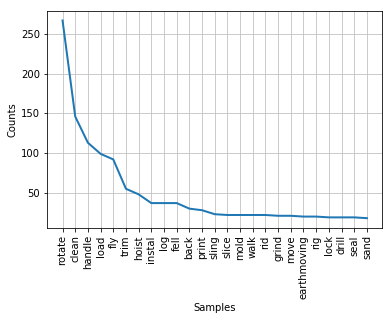

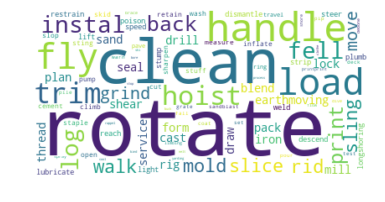

Top 3 activity word and their sentences


rotate

rotating parts hand
rotating parts work rules
rotating shaft
rotating parts
rotating parts rotating shaft
rotating shaft chain sprocket
rotating parts finger
rotating parts
rotating parts
rotating parts aircraft propeller laceration fracture inattention



clean
=====

cleaning conveyor
cleaning pump
cleaning air
cleaning air
cleaning point
cleaning air
cleaning fall struck
cleaning conveyor
cleaning rotating parts
cleaning printing machine



handle

handling auger cleaning
handling grain
handling motor vehicle
handling auger auger mechanism
handling fall
handling work rules
handling work rules
handling falling object bleach chemical burn leg
handling roller
handling lockout


Falls


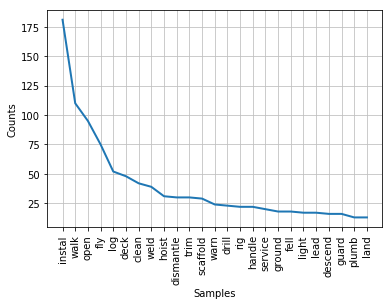

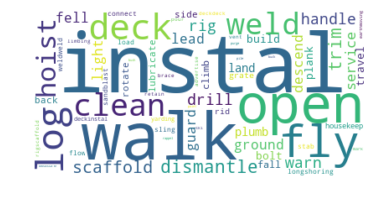

Top 3 activity word and their sentences


instal

installing ladder scaffold structure
installing arm fracture face abrasion
installing work rules
installing wrist
installing stakes
installing wall
installing skylight fall fall protection neck fracture
installing air conditioner
installing air conditioner
installing mixer blade hand tool electric drill



walk
====

walking surface
walking surface
walking backward inattention skylight
walking surface
walking backward fracture head
walking on beam
walking surface fall fracture
walking surface fall protection ppe barrier guard
walking backward construction fall fracture floor
walking surface barrier guard



open
====

opening cover ladder
opening work rules
opening fall protection fall demolition construction asbestos removal work rules
opening cover fall fracture head
opening bee sting roof
opening fall fall protection
opening maintenance ladder catwalk fall head fracture
opening ceiling panel fall protection
opening head
opening ceili

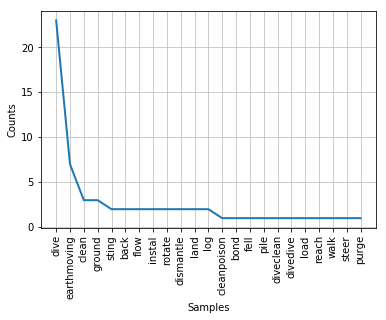

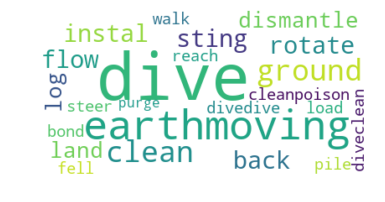

Top 3 activity word and their sentences


dive
====

diving commercial diving
diving drown scuba diving water
diving unconsciousness scuba commercial diving cpr diver water
diving cpr embolism
diving mech malfunction
diving commercial diving cpr scuba boat
diving air line swim work rules
diving gear scuba water
diving drown unconsciousness cpr
diving cpr



earthmoving

earthmoving equip equipment operator
earthmoving equip bulldozer heat exchanger pressure release
earthmoving equip bulldozer
earthmoving equip
earthmoving equip
earthmoving equip



clean
=====

cleaning poisoning skin ppe
cleaning bee
cleaning drown seizure construction water unconsciousness
cleaning seizure water drown


Other


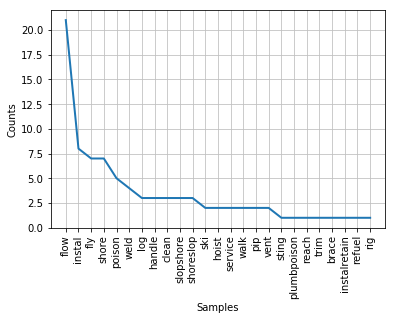

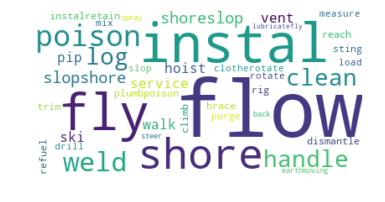

Top 3 activity word and their sentences


flow
====

flowing material
flowing material
flowing material
flowing material
flowing material
flowing material winch vibrations
flowing material safety
flowing material
flowing material work rules
flowing material



instal

installing stomach loss
installing retaining wall collapse
installing sewage wall
installing cave-in asphyxiated drain
installing pipe
installing hydraulic lift caught
installing trench box collapse
installing pipe trench trench digger
installing pipe undrgrd installation



fly
===

flying object equipment failure
flying object lockout
flying object construction pressure release work rules
flying object high pressure
flying object
flying object construction excavation
flying object


Struck By Moving Objects


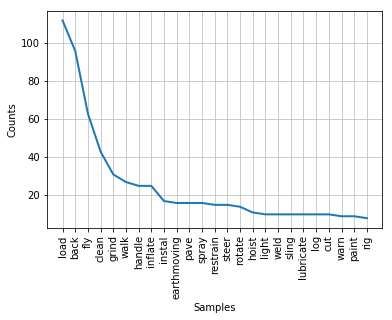

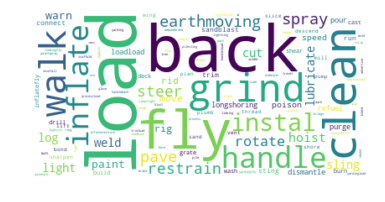

Top 3 activity word and their sentences


load
====

loading ramp loading dock
loading machinist abrasive wheel
loading trailer
loading agriculture heat heat exhaustion vomit alcohol
loading dock overturn
loading tractor trailer pallet loading dock run
loading asphalt burn
loading dock trailer truck
loading dock
loading trailer backhoe



back
====

backing up brake accelerator pedal
backing up accelerator pedal
backing up back-up alarm
backing up back-up alarm
backing up back-up alarm struck
backing up back-up alarm
backing up back-up alarm struck
backing up back-up alarm
backing up leg fracture motor vehicle
backing up back-up alarm highway road



fly
===

flying object eye ppe
flying object mechanic guard
flying object
flying object fracture hand emergency response
flying object face fracture chain
flying object fracture arm
flying object high pressure blowout
flying object bus
flying object maintenance chock trailer slip jack
flying object motor vehicle tank


Collapse of object


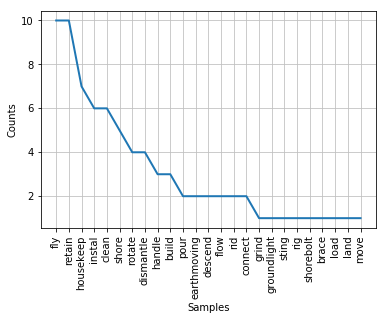

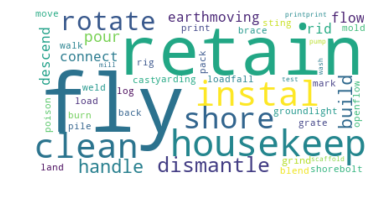

Top 3 activity word and their sentences


fly
===

flying object struck
flying object building
flying object
flying object chest
flying object leg
flying object
flying object
flying object press
flying object metal strip laceration eye ppe
flying object



retain

retaining wall
retaining wall bracing collapse
retaining wall collapse alarm struck
retaining wall collapse
retaining wall
retaining wall
retaining wall lawn mower
retaining wall
retaining wall collapse cleaning demolition
retaining wall underpinning



housekeep

housekeeping allergic reaction
housekeeping vapor
housekeeping cleaning vacuum
housekeeping janitor cleaning
housekeeping amputated finger paint cleaning
housekeeping chemical arm pressure release cleaning spill
housekeeping vacuum


Fires and Explosion


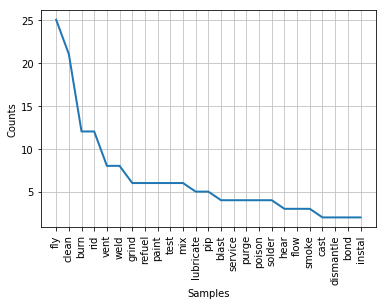

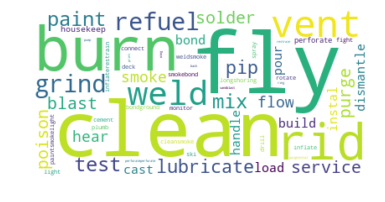

Top 3 activity word and their sentences


fly
===

flying object explosion boiler gas leak contusion abrasion food preparation arm
flying object bolt stepladder explosion
flying object head
flying object
flying object chemical chemical reaction contusion
flying object laceration eye face
flying object pyrotechnics
flying object arm laceration
flying object
flying object



clean
=====

cleaning explosion fire burn work rules cleaning fluid ventilation
cleaning carbon disulfide tank
cleaning burn fire head mixer tank
cleaning fluid
cleaning coal tar
cleaning work rules
cleaning flammable vapors
cleaning laceration
cleaning process safety explosives
cleaning smoking flammable liquid



burn
====

burning naphtha fire
burning drum
burning torch oxygen propylene
burn chemical fertilizer mixing irrigation equipment water pump explosion nitrogen chest face
burning flammable liquid torch explosion burn face
burning demolition gas
burning explosion burn fire
burning work rules
burning contusio

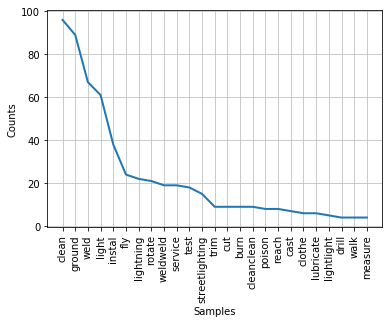

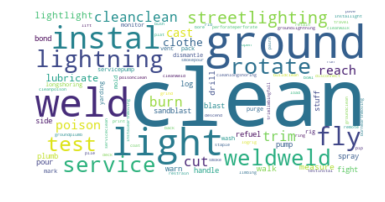

Top 3 activity word and their sentences


clean
=====

cleaning work rules
cleaning welding fire
cleaning fluid work rules
cleaning ppe work rules
cleaning tendon laceration puncture
cleaning fan fan
cleaning box lid
cleaning brush chipper milling machine guard
cleaning water tank
cleaning poisoning carbon monoxide ventilation gasoline



ground

grounding untrained e gi vii
grounding attachment plug
grounding cord
grounding conveyor
grounding electric cord attachment plug pump wet operation
grounding attachment plug
grounding elec equipment
grounding welder attachment plug e gi v
grounding electric generator
grounding cord connector attachment plug cord



weld
====

welding pipe plug pipeline excavation sump tank oxygen
welding alcohol glove hand duct
welding electric arc arc welding maintenance fire burn ppe cutting
welding welding oil drum explosion burn
welding burn arm lubricating fluid pipeline
welding welding pipe explosion
welding burn ppe clothing arc
welding burn ppe spark c

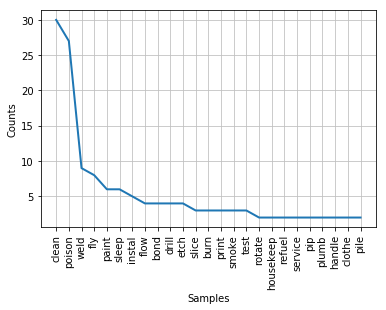

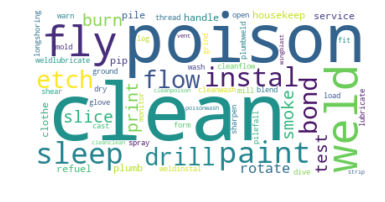

Top 3 activity word and their sentences


clean
=====

cleaning fluid lung air contamination toxic fumes
cleaning anhydrous ammonia chemical vapor chemical inhalation work rules
cleaning meat blending mach lockout machine
cleaning flammable vapors
cleaning benzene static electricity
cleaning bleach chemical reaction
cleaning fluid toxic fumes
cleaning ppe storage tank carbon disulfide
cleaning oxygen electric drill arm face
cleaning unconsciousness inhalation chemical vapor vapor ppe



poison

poisoning heat exhaustion
poisoning emergency response
poisoning inhalation ventilation
poisoning chemical vapor
poisoning chlorine gas cylinder throat cough vomit eye
poisoning chemical vapor press operator chemical
poisoning inhalation exhaust
poisoning lawn
poisoning ventilation work rules heart
poisoning exhaust fumes



weld
====

welding lubricating fluid oil tank explosion gas gas
welding protective clothing ppe toxic fumes
welding installing burn fire
welding welder explosion fire smoke 

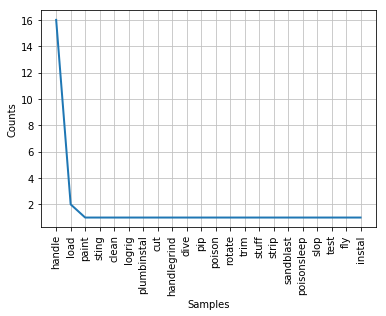

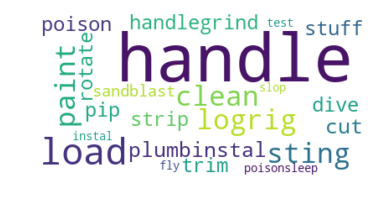

Top 3 activity word and their sentences


handle

handling baggage conveyor
handling chair sprain
handling heart
handling burn torso
handling grinding wheel equipment failure
handling fire burn
handling maintenance
handling infection shoulder
handling wheel stuck fall
handling puncture hand infection glove ppe



load
====

loading manual mat handling corn
loading allergic reaction inhalation



paint
=====

painting hexane xylene acetone lung inhalation


Exposure to extreme temperatures


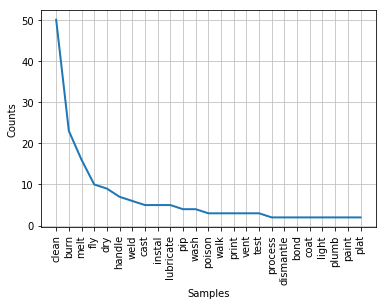

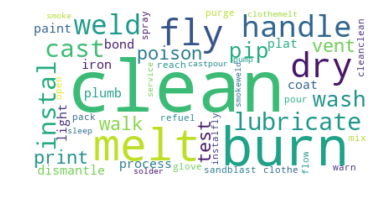

Top 3 activity word and their sentences


clean
=====

cleaning chemical burn ppe jet fuel hand
cleaning acetone fire burn
cleaning hopper coal hatch burn
cleaning maintenance
cleaning ash high temperature
cleaning work rules
cleaning burn chemical
cleaning burn
cleaning chemical burn foot ankle
cleaning disinfectant chemical burn arm



burn
====

burning torch acetylene torch burn explosion hearing loss face neck chest arm
burning leg burn fire fire extinguisher
burning flammable vapors
burning air monitoring
burning drum isopropyl alcohol explosion torch
burning torch scrap metal baler welder
burn chemical burn pressure piping pressure release
burning torch
burning fire burn clothing
burning beam fracture



melt
====

melting furnace
melting furnace jack
melting furnace explosion
melting furnace plastic mfg
melting furnace steel molten
melting furnace explosion burn
melting furnace scrap metal steel
melting furnace water chemical work rules
melting furnace furnace chemical reaction

In [13]:
if ProcessOshaDataSet:
    chunk_count = 0
    verb_count = 0
    for cat in OshaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Osha Extraction Chunk Count is " +  str(chunk_count))
    print("Osha Extraction Verb Count is " +  str(verb_count))       

# Output to excel file with new additional columns for activity and activity chunks

In [14]:
#Write to excel with the additional columns for activity verb 
if ProcessMsiaDataSet:
    NewColumn1 = []
    NewColumn2 = []
    for item in MsiaCaseItems:
        if item.ActivityTokensVerb == []:
            NewColumn1.append("")
            NewColumn2.append("")
        else:
            NewColumn1.append(','.join(item.ActivityTokensVerb))
            NewColumn2.append(','.join(item.ActivityTokensChunk))
    MsiaCasesDF.eval("ActivityVerb = @NewColumn1", inplace=True)
    MsiaCasesDF.eval("ActivityChunk = @NewColumn2", inplace=True)
    WriteToExcel('MsiaWithActivity.xlsx',OshaCasesDF)

if ProcessOshaDataSet:
    NewColumn1 = []
    NewColumn2 = []
    for item in OshaCaseItems:
        if item.ActivityTokensVerb == []:
            NewColumn1.append("")
            NewColumn2.append("")
        else:
            NewColumn1.append(','.join(item.ActivityTokensVerb))
            NewColumn2.append(','.join(item.ActivityTokensChunk))
    OshaCasesDF.eval("ActivityVerb = @NewColumn1", inplace=True)
    OshaCasesDF.eval("ActivityChunk = @NewColumn2", inplace=True)
    WriteToExcel('OshaWithActivity.xlsx',OshaCasesDF)


# Notes and Observation: 
- For the Msia dataset which is used as training dataset, the summary columns are mostly made up of complete grammatically sound sentences and thus the regular expression parser method is chosen to extract the activity phrases.

- However, for the Osha dataset, not all sentences are complete and grammatically sound like the Msia dataset. Some of the activities descripton in the summary column are made up of just keywords instead of complete sentences thus that could result in these rows data being omitted when perform the regular expression parsing. Thus only about 5000 of the 16000 rows in which activity can be found using the parser developed in Msia dataset.

- Further improvements: Need to tweak the reg parser to cater for the "keywords" style description in the OSHA dataset. Some of the activities captured are actually describing the cause of the incident, thus in order to get a more accurate text mining on activities, prior domain knowledge on what is considered cause and what is activities need to be incorporated.